# **WGAN-GP: CelebA**  

**Data**  
> https://www.kaggle.com/jessicali9530/celeba-dataset  

In [2]:
import torch
import torch.nn as nn
import torchvision.utils as utils
import torch.optim as optim 
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import itertools

import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import pickle
import random

In [14]:
workers = 2
batch_size = 64
nz = 100
nc = 3
image_size = 64

epochs = 50
lr = 0.0002
beta1 = 0.5
lamb = 10
isCuda = True

device = torch.device("cuda:0" if (torch.cuda.is_available() and isCuda) else "cpu")
torch.backends.cudnn.benchmark = True

model_saved_dir = "./model"

print("Device: ", end="")
print(device)

Device: cuda:0


In [10]:
import os.path

if os.path.isfile('~/.kaggle/kaggle.json'):
  print("Already kaggle.json exsits.")
else:
  !mkdir -p ~/.kaggle
  !cp ./kaggle.json ~/.kaggle/ 
  !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d jessicali9530/celeba-dataset
if os.path.isdir('./img_align_celeba'):
  print("Already unzip.")
else:
  !unzip -q celeba-dataset.zip
  print("Unzip Complete!")

100%|██████████████████████████████████████▉| 1.33G/1.33G [00:13<00:00, 162MB/s]
100%|███████████████████████████████████████| 1.33G/1.33G [00:13<00:00, 103MB/s]
Unzip Complete!


In [5]:
dataset = datasets.ImageFolder(root='./img_align_celeba',
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

In [6]:
# Restore images to suitable images of opencv style
def ImgForPlot(img):
  img = np.einsum('ijk->jki', img)
  img = (127.5*(img+1)).astype(np.uint8)
  return img

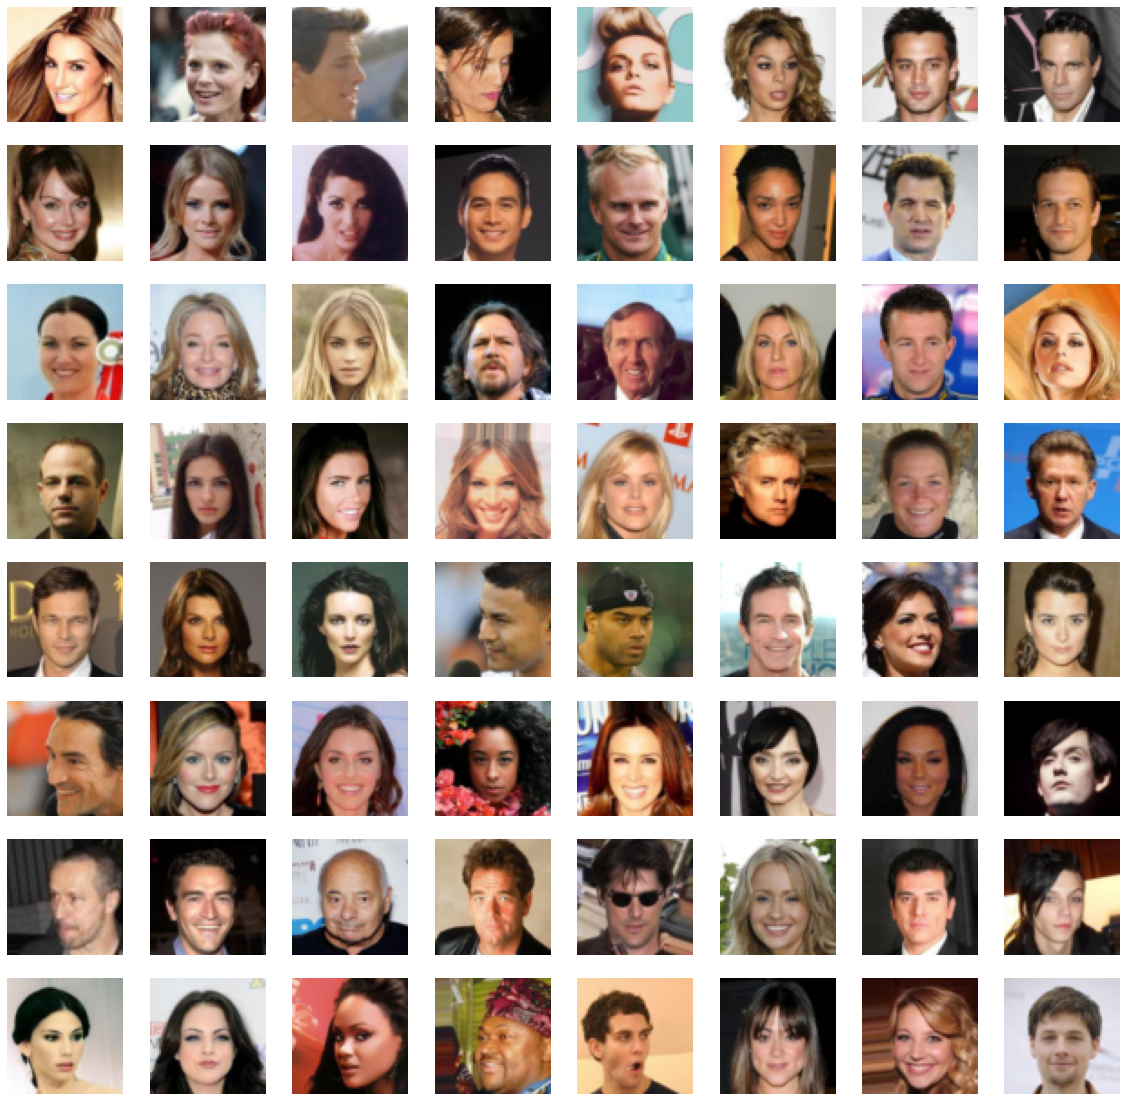

In [7]:
fig = plt.figure(figsize=(20,20))

for k in range(64):
  img, idx = dataset[k]
  ax = fig.add_subplot(8, 8, k+1)
  ax.imshow(ImgForPlot(img))
  ax.axis("off")

plt.show()

## Generator  

1x1x(nz) → 4x4x1024 → 8x8x512 → 16x16x256 → 32x32x128 → 64x64x3

In [8]:
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [9]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        # 1 x 1 x nz
        nn.ConvTranspose2d(nz, 1024, 4, 1, 0, bias=False),
        nn.ReLU(inplace=True),
        # 4 x 4 x 1024
        nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        # 8 x 8 x 512
        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        # 16 x 16 x 256
        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        # 32 x 32 x 128
        nn.ConvTranspose2d(128, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        # 64 x 64 x nc
    )

  def forward(self, x):
    return self.main(x)

## Discriminator

64x64x3 → 32x32x64 → 16x16x128 → 8x8x256 → 4x4x512 → 1x1x1

In [10]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        # 64x64x3
        nn.Conv2d(nc, 64, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # 32x32x64
        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # 16x16x128
        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # 8x8x256
        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        # 4x4x512
        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
        nn.Sigmoid()
        # 1x1x1
    )

  def forward(self, x):
    return self.main(x)

## Gradient Penalty

In [15]:
def calc_gradient_penalty(b_size, netD, real_data, fake_data):
    alpha = torch.rand(b_size, 1)
    alpha = alpha.expand(real_data.size())
    alpha = alpha.cuda()

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = Variable(interpolates, requires_grad=True).cuda()

    disc_interpolates = netD(interpolates)

    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                  grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                                  create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lamb
    
    return gradient_penalty

## Making models & Weight initialization

In [11]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [12]:
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## (Option) Load models and lists

In [ ]:
model_name = 'WGAN-GP_CelebA_autosave'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

with open(img_list_path, 'rb') as f:
  img_list = pickle.load(f)
with open(losses_path, 'rb') as f:
  G_losses, D_losses = pickle.load(f)

netG.load_state_dict(torch.load(G_path))
netD.load_state_dict(torch.load(D_path))

## Loss Functions and Optimizers

In [13]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_num = 1
fake_num = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1,0.999))

## Training

In [ ]:
start_epoch = 0
continueTrain = False

if start_epoch == 0 and not continueTrain:
  img_list, G_losses, D_losses = [], [], []

model_name = 'LSGAN_CelebA_autosave'

img_list_path = F"{model_saved_dir}/{model_name}_img_list.txt"
losses_path = F"{model_saved_dir}/{model_name}_losses.txt"
G_path = F"{model_saved_dir}/{model_name}_G.pt"
D_path = F"{model_saved_dir}/{model_name}_D.pt"

netD.train()
netG.train()
for ep in range(start_epoch, epochs):
  for batch_idx, (image, lbl) in enumerate(dataloader, 0):

    b_size = image.shape[0]
    image = Variable(image).cuda()
    label = torch.full((b_size,), real_num, device=device)
    label = label.type(torch.cuda.FloatTensor)
    
    # 1. Update Discriminator
    # 1-1. Train with Real Batch
    netD.zero_grad()

    output = netD(image).view(-1)
    errD_real = criterion(output, label)
    errD_real.backward()
    D_x = output.mean().item()

    # 1-2. Train with Fake Batch
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    fake = netG(noise)
    label.fill_(fake_num)

    output = netD(fake.detach()).view(-1)
    errD_fake = criterion(output, label)
    errD_fake.backward()
    D_G_z1 = output.mean().item()

    errD = 0.5 * (errD_real + errD_fake)
    optimizerD.step() 
    
    # 2. Update Generator
    netG.zero_grad()
    label.fill_(real_num)

    output = netD(fake).view(-1)
    errG = criterion(output, label)
    errG.backward()
    D_G_z2 = output.mean().item()
    optimizerG.step()

    if batch_idx % 50 == 49:
      print('[%2d/%2d][%3d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' 
            % (ep+1, epochs, batch_idx+1, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
      G_losses.append(errG.item())
      D_losses.append(errD.item())
  
  with torch.no_grad():
    fake = netG(fixed_noise).detach().cpu()
    img_list.append(fake)

  torch.save(netG.state_dict(), G_path)
  torch.save(netD.state_dict(), D_path)

  with open(img_list_path, 'wb') as f:
    pickle.dump(img_list, f)
  with open(losses_path, 'wb') as f:
    pickle.dump((G_losses, D_losses), f)